In [1]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random

from model import CPH
from evolution import Genetic, CPHMaxCindex

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mpl
from IPython.display import display 
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve

In [2]:
exp_dir = '25'

correct_labels_p=0.25
censoring_p_orig=0.50

max_iters = 1000

# Loading Results

In [3]:
g_exp_best_train_hist = np.load(f'results/{exp_dir}/g_exp_best_train_hist_{censoring_p_orig}_{correct_labels_p}.npy')
g_exp_best_test_hist = np.load(f'results/{exp_dir}/g_exp_best_test_hist_{censoring_p_orig}_{correct_labels_p}.npy')
g_accs_test = np.load(f'results/{exp_dir}/g_accs_test_{censoring_p_orig}_{correct_labels_p}.npy')
g_accs_train = np.load(f'results/{exp_dir}/g_accs_train_{censoring_p_orig}_{correct_labels_p}.npy')

g_ones_accs_test = np.load(f'results/{exp_dir}/g_ones_accs_test_{censoring_p_orig}_{correct_labels_p}.npy')
g_ones_accs_train = np.load(f'results/{exp_dir}/g_ones_accs_train_{censoring_p_orig}_{correct_labels_p}.npy')

g_exp_new_unknown_true_e_test = np.load(f'results/{exp_dir}/g_exp_new_unknown_true_e_test_{censoring_p_orig}_{correct_labels_p}.npy')
g_exp_new_unknown_true_e_train = np.load(f'results/{exp_dir}/g_exp_new_unknown_true_e_train_{censoring_p_orig}_{correct_labels_p}.npy')

g_exp_x_test = np.load(f'results/{exp_dir}/g_exp_x_test_{censoring_p_orig}_{correct_labels_p}.npy')
g_exp_x_train = np.load(f'results/{exp_dir}/g_exp_x_train_{censoring_p_orig}_{correct_labels_p}.npy')
g_exp_e_test = np.load(f'results/{exp_dir}/g_exp_e_test_{censoring_p_orig}_{correct_labels_p}.npy')
g_exp_e_train = np.load(f'results/{exp_dir}/g_exp_e_train_{censoring_p_orig}_{correct_labels_p}.npy')
g_exp_new_known_time_test = np.load(f'results/{exp_dir}/g_exp_new_known_time_test_{censoring_p_orig}_{correct_labels_p}.npy')
g_exp_new_known_time_train = np.load(f'results/{exp_dir}/g_exp_new_known_time_train_{censoring_p_orig}_{correct_labels_p}.npy')


g_exp_e_test = np.load(f'results/{exp_dir}/g_exp_e_test{censoring_p_orig}_{correct_labels_p}.npy')
g_exp_e_train = np.load(f'results/{exp_dir}/g_exp_e_train_{censoring_p_orig}_{correct_labels_p}.npy')

g_log_dfs = []
for i in range(max_iters):
    df_temp = pd.read_csv(f'results/{exp_dir}/dfs/log_df_{i}.csv')
    g_log_dfs.append(df_temp)


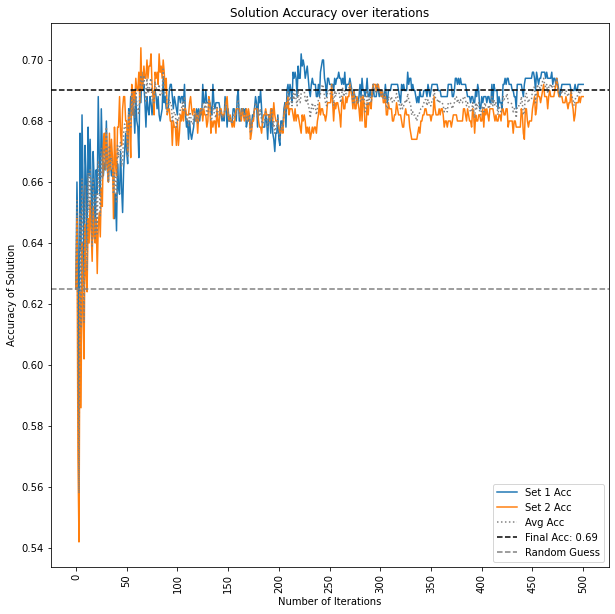

In [16]:
random_acc = correct_labels_p**2 + (1-correct_labels_p)**2

plt.figure(figsize=(10,10))

g_accs_test_temp = np.insert(g_accs_test, 0, random_acc)
g_accs_train_temp = np.insert(g_accs_train, 0, random_acc)


plt.plot(range(0,int((max_iters/2)+1)), g_accs_test_temp, label='Set 1 Acc')
plt.plot(range(0,int((max_iters/2)+1)), g_accs_train_temp, label='Set 2 Acc')
mean_acc = (g_accs_test_temp + g_accs_train_temp)/2
plt.plot(mean_acc, c='gray', ls=':', label='Avg Acc')
plt.axhline(mean_acc[-1], c='k', ls='--', label='Final Acc: {:.2f}'.format(mean_acc[-1]))
plt.axhline(random_acc, c='gray', ls='--', label='Random Guess')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy of Solution')
plt.xticks(range(0,int((max_iters/2)+1),50), rotation=90)
plt.title('Solution Accuracy over iterations')
plt.legend()
plt.savefig(f'results/{exp_dir}/figs/accs_iterations_{censoring_p_orig}_{correct_labels_p}.png')

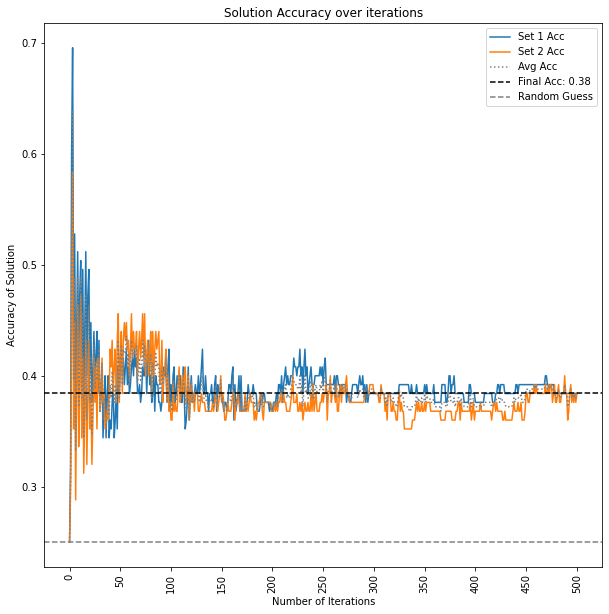

In [18]:
g_ones_accs_test_temp = np.insert(g_ones_accs_test, 0, correct_labels_p)
g_ones_accs_train_temp = np.insert(g_ones_accs_train, 0, correct_labels_p)


plt.figure(figsize=(10,10))
plt.plot(range(0,int((max_iters/2)+1)),g_ones_accs_test_temp, label='Set 1 Acc')
plt.plot(range(0,int((max_iters/2)+1)),g_ones_accs_train_temp, label='Set 2 Acc')
mean_acc = (g_ones_accs_test_temp+g_ones_accs_train_temp)/2
plt.plot(mean_acc, c='gray', ls=':', label='Avg Acc')
plt.axhline(mean_acc[-1], c='k', ls='--', label='Final Acc: {:.2f}'.format(mean_acc[-1]))
plt.axhline(correct_labels_p, c='gray', ls='--', label='Random Guess')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy of Solution')
plt.xticks(range(0,int((max_iters/2)+1),50), rotation=90)
plt.title('Solution Accuracy over iterations')
plt.legend()
plt.savefig(f'results/{exp_dir}/figs/ones_accs_iterations_{censoring_p_orig}_{correct_labels_p}.png')

In [6]:
accum_e_test_ps = g_exp_best_test_hist.mean(axis=0)
cut_val_test = np.percentile(accum_e_test_ps, 100-correct_labels_p*100)

accum_e_train_ps = g_exp_best_train_hist.mean(axis=0)
cut_val_train = np.percentile(accum_e_train_ps, 100-correct_labels_p*100)

cut_val_test, cut_val_train

(0.367, 0.372)

In [7]:
best_e_test = (g_exp_best_test_hist.mean(axis=0)>=cut_val_test).astype(int)
best_e_train = (g_exp_best_train_hist.mean(axis=0)>=cut_val_train).astype(int)

e_test_small = g_exp_new_unknown_true_e_test[g_exp_e_test==1]
e_train_small = g_exp_new_unknown_true_e_train[g_exp_e_train==1]

In [8]:
ones_acc_train = ((best_e_train == 1) & (e_train_small == 1)).sum() / e_train_small.sum()
ones_acc_test = ((best_e_test == 1) & (e_test_small == 1)).sum() / e_test_small.sum()

print('Train Ones Acc: {:.2f}\nTest Ones Acc: {:.2f}'.format(ones_acc_train, ones_acc_test))

Train Ones Acc: 0.38
Test Ones Acc: 0.38


In [9]:
best_e = np.concatenate([best_e_test, best_e_train])
e_small = np.concatenate([e_test_small, e_train_small])

In [10]:
best_e.mean()

0.252

# Final acc

In [11]:
(best_e==e_small).mean()

0.69

# Final ones acc

In [12]:
((best_e == 1) & (e_small == 1)).sum() / e_small.sum()

0.384

# Ones P

In [13]:
best_e.mean()

0.252

In [22]:
def auc_func(e_true, e_pred_pr, title='ROC', verbose=True, idx=0, save=False, c=1):
    #plt.figure()
    fpr, tpr, thresholds = roc_curve(e_true, e_pred_pr)
    auc_val = auc(fpr, tpr)
    #cut_val = np.median(e_pred_pr)
    cut_val = np.percentile(e_pred_pr, 100-correct_labels_p*100)
    e_pred = (e_pred_pr >= cut_val).astype(int)
    ones_acc = ((e_pred == 1) & (e_true == 1)).sum() / e_true.sum()
    zeros_acc = ((e_pred == 0) & (e_true == 0)).sum() / (~e_true.astype(bool)).sum()
    acc = (e_pred == e_true).mean()
    color = cm.viridis(np.linspace(0, 1, int((max_iters/2)+1)))
    ax=plt.plot(fpr, tpr, label=title+'\nAUC: {:.2f}\nAcc: {:.2f}'.format(auc_val, acc), c=color[c], alpha=0.4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color="C1", linestyle="--", alpha=0.01)
    if verbose:
        plt.axvline(cut_val, color=color[c], alpha=0.2)
        plt.legend()
    if save:
        plt.savefig(f'results/{exp_dir}/figs/roc__{censoring_p_orig}_{correct_labels_p}_{idx}.png')
    return fpr, tpr, auc_val, acc, ones_acc, zeros_acc


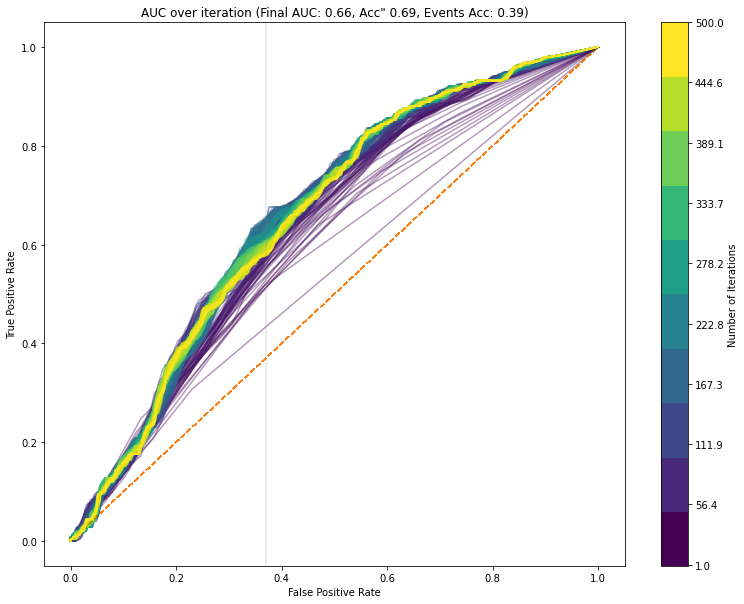

In [25]:
plt.figure(figsize=(13,10))
fprs, tprs = [], []
for i in range(1, len(g_exp_best_test_hist)):
    best_e_test_pr_i = np.array(g_exp_best_test_hist[:i]).mean(axis=0)
    best_e_train_pr_i = np.array(g_exp_best_train_hist[:i]).mean(axis=0)
    best_e_pr_i = np.concatenate([best_e_test_pr_i, best_e_train_pr_i])
    
    cut_val_test = np.percentile(accum_e_test_ps, 100-correct_labels_p*100)
    cut_val_train = np.percentile(accum_e_train_ps, 100-correct_labels_p*100)
    

    
#     auc_func(e_test_small, best_e_test_pr, 'Test')
#     auc_func(e_train_small, best_e_train_pr, 'Train')
    #plt.figure()
    #print(best_e_pr_i)
    fpr, tpr, auc_val, acc, ones_acc, zeros_acc = auc_func(e_small, best_e_pr_i, '', verbose=False, idx=i, c=i)
    
    fprs.append(fpr), tprs.append(tpr)

cut_val = np.percentile(best_e_pr_i, 100-correct_labels_p*100)
plt.axvline(cut_val, color='gray', alpha=0.2)
cmap = cmap = plt.get_cmap('viridis',10)  
norm = mpl.colors.Normalize(vmin=0,vmax=int((max_iters/2)))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar= plt.colorbar(sm, ticks=np.linspace(1,int((max_iters/2)),10), boundaries=np.arange(0,int((max_iters/2))+0.1,.1))
cbar.set_label('Number of Iterations', rotation=90)
plt.title('AUC over iteration (Final AUC: {:.2f}, Acc" {:.2f}, Events Acc: {:.2f})'.format(auc_val, acc, ones_acc));
plt.savefig(f'results/{exp_dir}/figs/auc_{censoring_p_orig}_{correct_labels_p}.png')

In [29]:
e_test_small = g_exp_new_unknown_true_e_test[g_exp_e_test==1]
t_test_small = g_exp_new_known_time_test[g_exp_e_test==1]
e_train_small = g_exp_new_unknown_true_e_train[g_exp_e_train==1]
t_train_small = g_exp_new_known_time_train[g_exp_e_train==1]

In [30]:
t_small = np.concatenate([t_test_small, t_train_small])
e_small = np.concatenate([e_test_small, e_train_small])

best_e_test_pr = np.array(g_exp_best_test_hist).mean(axis=0)
best_e_train_pr = np.array(g_exp_best_train_hist).mean(axis=0)
e_pred_pr = np.concatenate([best_e_test_pr, best_e_train_pr])

cut_val = np.percentile(e_pred_pr, 100-correct_labels_p*100)

e_pred = (e_pred_pr>=cut_val).astype(int)

t_small.shape, e_small.shape, e_pred_pr.shape

((1000,), (1000,), (1000,))

In [38]:
df1 = pd.DataFrame()
df1['E'] = e_small.astype(int)
df1['T'] = t_small
df1['P'] = e_pred_pr
df1['Ep'] = e_pred

In [39]:
d = pd.cut(df1["P"],
       bins=[-0.1, 0.1 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
       labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [40]:
df1['C'] = d

In [41]:
df1

,E,T,P,Ep,C
0,0,0.244276,0.000,0,1
1,1,0.748359,0.336,0,4
2,0,1.311235,0.520,1,6
3,0,26.521260,0.148,0,2
4,0,2.737146,0.358,0,4
...,...,...,...,...,...
995,0,0.049620,0.584,1,6
996,0,8.558485,0.286,0,3
997,0,5.042812,0.142,0,2
998,1,29.695440,0.250,0,3


In [44]:
zeros_ps = []
for i in range(1, 11):
    ones_acc = ((df1.loc[(df1['C']==i), 'E']==1) & (df1.loc[(df1['C']==i), 'Ep']==1)).mean()
    zeros_acc = ((df1.loc[(df1['C']==i), 'E']==0) & (df1.loc[(df1['C']==i), 'Ep']==0)).mean()
    zeros_p = (df1.loc[(df1['C']==i), 'E']==0).mean()
    ones_p = (df1.loc[(df1['C']==i), 'E']==1).mean()
    print(f'Conf: {i}, zeros_p: {zeros_p:.2f}, ones_p: {ones_p:.2f}, zeros_acc: {zeros_acc:.2f}')
    zeros_ps.append(zeros_p)

Conf: 1, zeros_p: 0.90, ones_p: 0.10, zeros_acc: 0.90
Conf: 2, zeros_p: 0.82, ones_p: 0.17, zeros_acc: 0.82
Conf: 3, zeros_p: 0.71, ones_p: 0.29, zeros_acc: 0.71
Conf: 4, zeros_p: 0.66, ones_p: 0.34, zeros_acc: 0.53
Conf: 5, zeros_p: 0.65, ones_p: 0.35, zeros_acc: 0.00
Conf: 6, zeros_p: 0.64, ones_p: 0.36, zeros_acc: 0.00
Conf: 7, zeros_p: 0.67, ones_p: 0.33, zeros_acc: 0.00
Conf: 8, zeros_p: nan, ones_p: nan, zeros_acc: nan
Conf: 9, zeros_p: nan, ones_p: nan, zeros_acc: nan
Conf: 10, zeros_p: nan, ones_p: nan, zeros_acc: nan


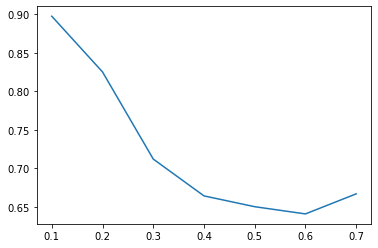

In [53]:
plt.plot(np.arange(1, 11)*0.1,zeros_ps)